In [1]:
import glob
import matplotlib.pyplot
import matplotlib
import sys
import time
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin, argrelextrema

# enable zooming into graphs
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 5)

def pull_data(dir_name, file_name, separator=';'):
    f = open(dir_name + '/' + file_name + '.csv')
    xs = []
    ys = []
    zs = []
    rs = []
    timestamps = []
    f.readline() # ignore separator declaration
    f.readline() # ignore header
    for line in f:
        value = line.split(separator)
        if len(value) > 3:
            t=value[6].strip()
            timestamps.append(t)
            x = float(value[0])
            y = float(value[1])
            z = float(value[2])
            r = math.sqrt(x ** 2 + y ** 2 + z ** 2)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            rs.append(r)
    return np.array(xs), np.array(ys), np.array(zs), np.array(rs), np.array(timestamps)

<IPython.core.display.Javascript object>


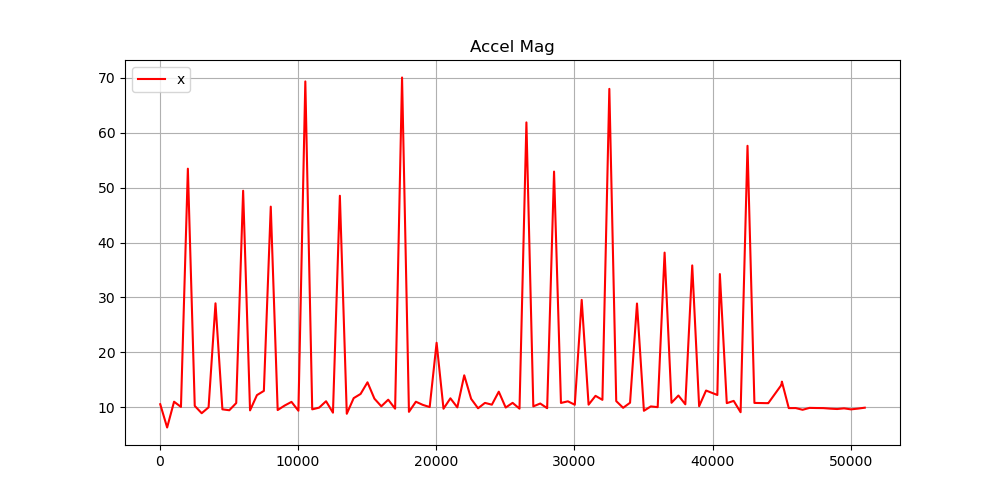

In [2]:
#Back hand throws (supposed to be 25)
b25_raw_data = pull_data('data', 'Backhand25HSB')
(b25_accel_x, b25_accel_y, b25_accel_z, b25_accel_mag, b25_accel_time_temp) = b25_raw_data

b25_accel_time = b25_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
plt.plot(b25_accel_time, b25_accel_mag, 'r-',label="x")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


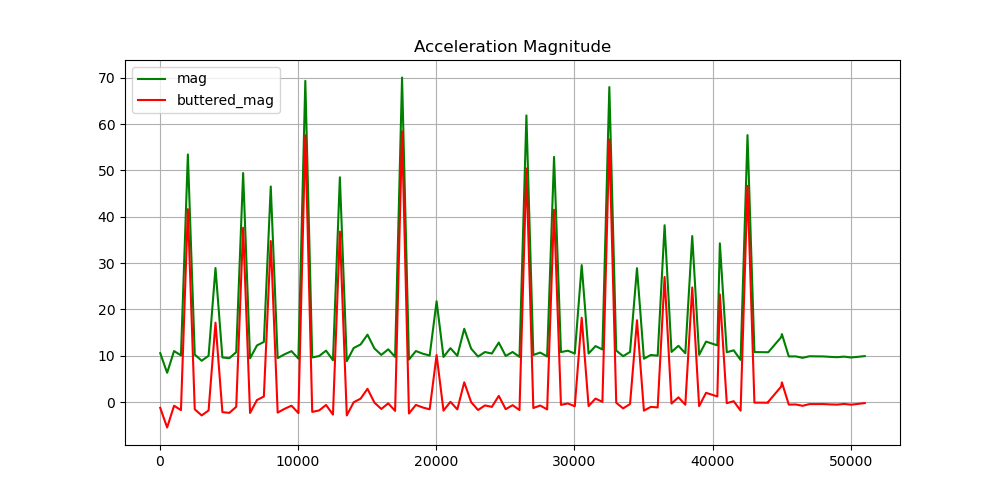

In [3]:
#ButterWorth Filter on Magb25
b25_accel_mag_copy = b25_accel_mag.copy()
order = 1
fs = 500 #Sampling Frequency
cutoff = 0.5
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='high', analog=False)
b25_buttered_mag = filtfilt(b, a, b25_accel_mag)

plt.figure(figsize=(10,5))
plt.plot(b25_accel_time, b25_accel_mag, 'g-',label="mag")
plt.plot(b25_accel_time, b25_buttered_mag,  'r-',label="buttered_mag")
plt.title("Acceleration Magnitude")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [4]:
#Throw count


<IPython.core.display.Javascript object>


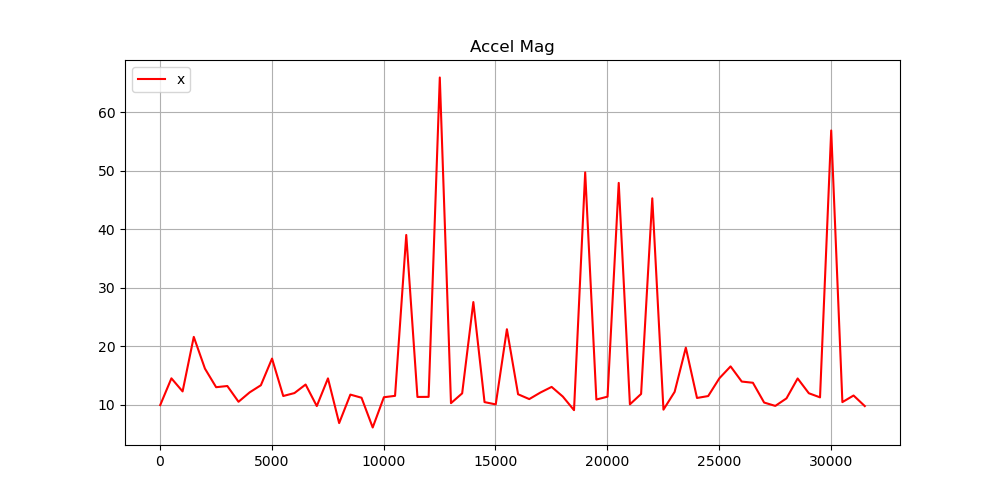

In [5]:
b10_raw_data = pull_data('data', 'Backhand10HSB')
(b10_accel_x, b10_accel_y, b10_accel_z, b10_accel_mag, b10_accel_time_temp) = b10_raw_data

b10_accel_time = b10_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
plt.plot(b10_accel_time, b10_accel_mag, 'r-',label="x")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


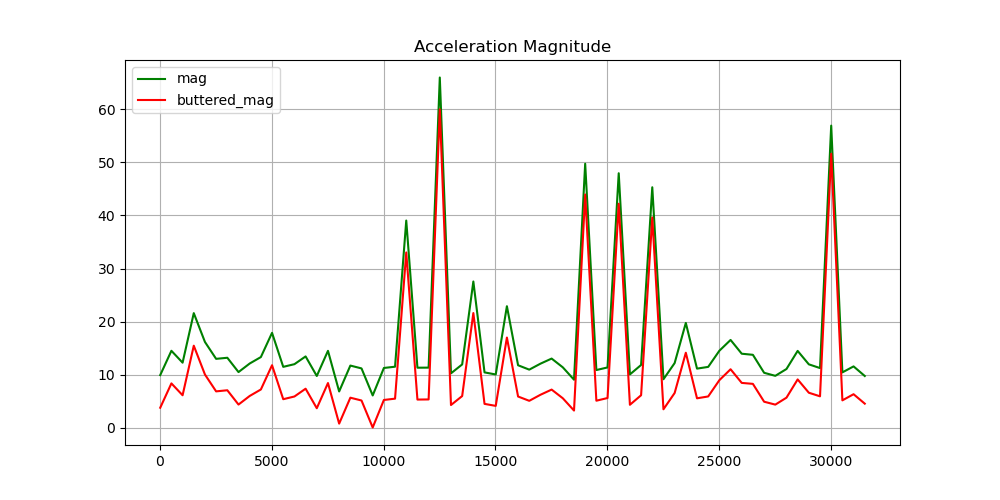

In [6]:
#ButterWorth Filter on Magb10
b10_accel_mag_copy = b10_accel_mag.copy()
order = 1
fs = 500 #Sampling Frequency
cutoff = 0.5
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='high', analog=False)
b10_buttered_mag = filtfilt(b, a, b10_accel_mag)

plt.figure(figsize=(10,5))
plt.plot(b10_accel_time, b10_accel_mag, 'g-',label="mag")
plt.plot(b10_accel_time, b10_buttered_mag,  'r-',label="buttered_mag")
plt.title("Acceleration Magnitude")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [7]:
#Throw count


<IPython.core.display.Javascript object>


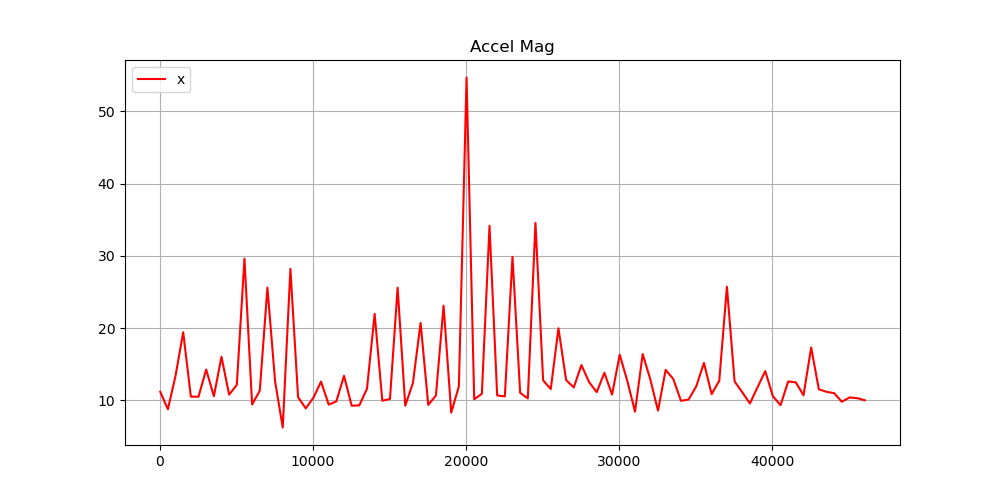

In [8]:
f25_raw_data = pull_data('data', 'Forehand25HSB')
(f25_accel_x, f25_accel_y, f25_accel_z, f25_accel_mag, f25_accel_time_temp) = f25_raw_data

f25_accel_time = f25_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
plt.plot(f25_accel_time, f25_accel_mag, 'r-',label="x")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


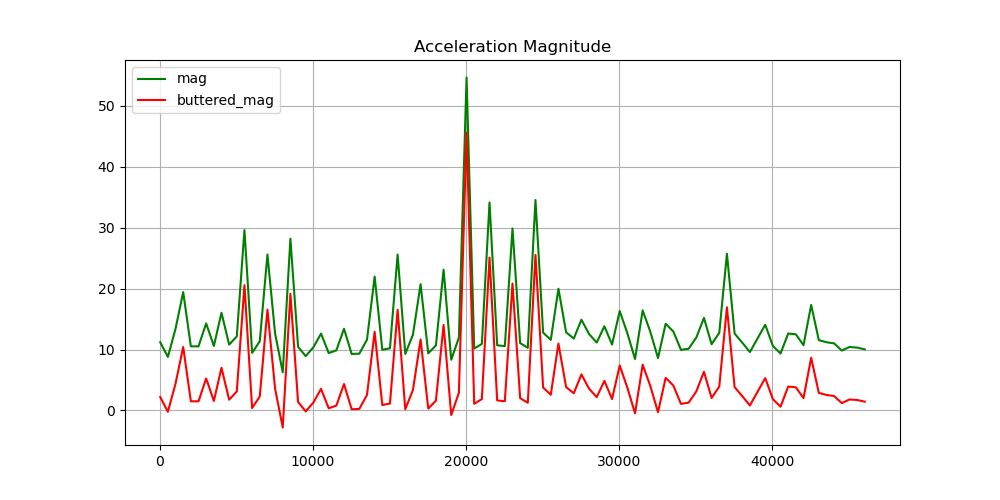

In [9]:
f25_accel_mag_copy = f25_accel_mag.copy()
order = 1
fs = 500 #Sampling Frequency
cutoff = 0.5
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='high', analog=False)
f25_buttered_mag = filtfilt(b, a, f25_accel_mag)

plt.figure(figsize=(10,5))
plt.plot(f25_accel_time, f25_accel_mag, 'g-',label="mag")
plt.plot(f25_accel_time, f25_buttered_mag,  'r-',label="buttered_mag")
plt.title("Acceleration Magnitude")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [10]:
#Throw count


<IPython.core.display.Javascript object>


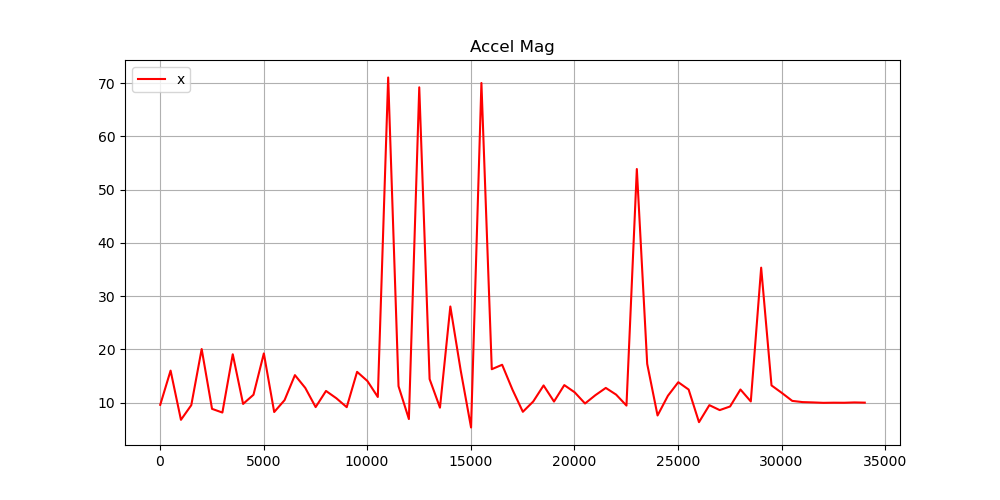

In [11]:
h10_raw_data = pull_data('data', 'Hammer10HSB')
(h10_accel_x, h10_accel_y, h10_accel_z, h10_accel_mag, h10_accel_time_temp) = h10_raw_data

h10_accel_time = h10_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
plt.plot(h10_accel_time, h10_accel_mag, 'r-',label="x")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


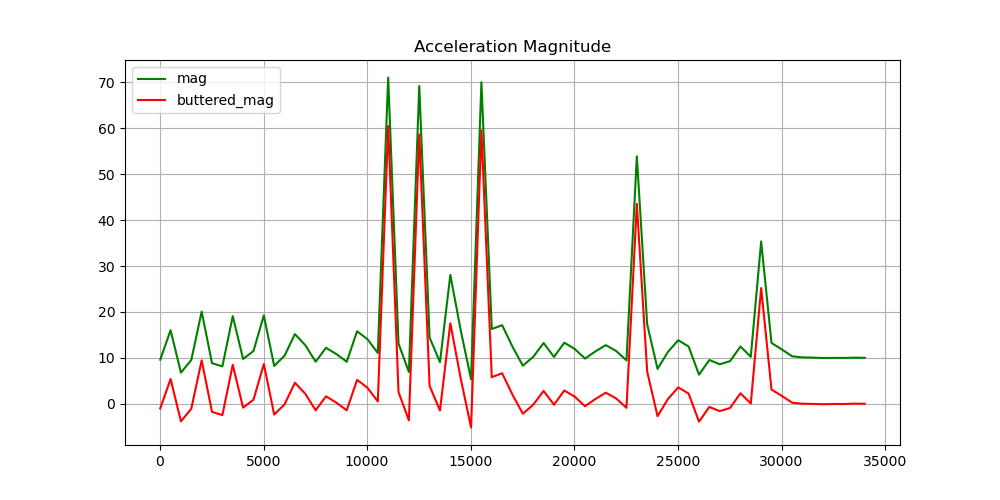

In [12]:
h10_accel_mag_copy = h10_accel_mag.copy()
order = 1
fs = 500 #Sampling Frequency
cutoff = 0.5
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='high', analog=False)
h10_buttered_mag = filtfilt(b, a, h10_accel_mag)

plt.figure(figsize=(10,5))
plt.plot(h10_accel_time, h10_accel_mag, 'g-',label="mag")
plt.plot(h10_accel_time, h10_buttered_mag,  'r-',label="buttered_mag")
plt.title("Acceleration Magnitude")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [13]:
#Throw count


<IPython.core.display.Javascript object>


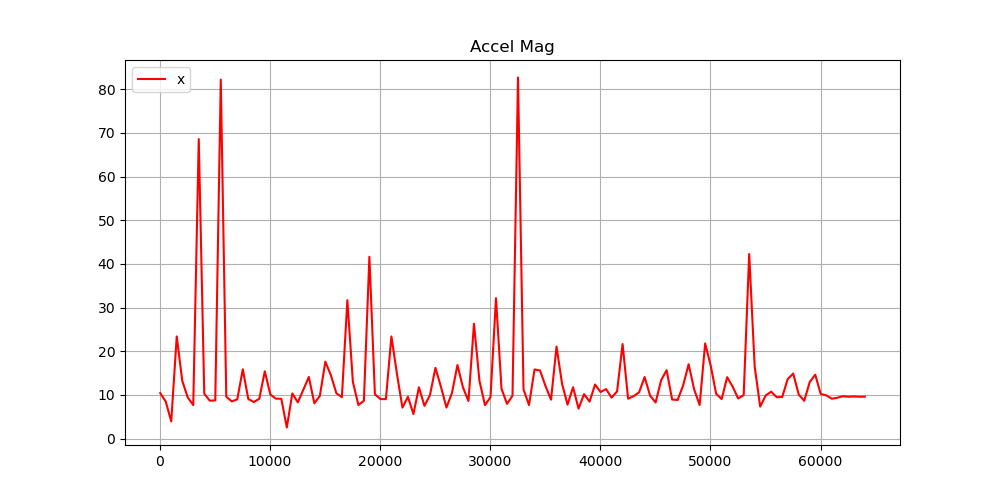

In [14]:
h25_raw_data = pull_data('data', 'Hammer25HSB')
(h25_accel_x, h25_accel_y, h25_accel_z, h25_accel_mag, h25_accel_time_temp) = h25_raw_data

h25_accel_time = h25_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
plt.plot(h25_accel_time, h25_accel_mag, 'r-',label="x")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


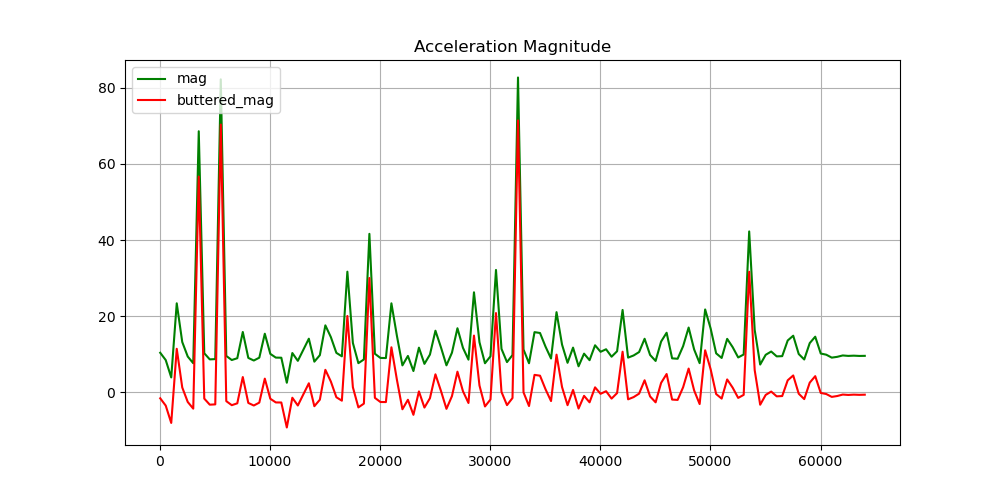

In [15]:
h25_accel_mag_copy = h25_accel_mag.copy()
order = 1
fs = 500 #Sampling Frequency
cutoff = 0.5
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='high', analog=False)
h25_buttered_mag = filtfilt(b, a, h25_accel_mag)

plt.figure(figsize=(10,5))
plt.plot(h25_accel_time, h25_accel_mag, 'g-',label="mag")
plt.plot(h25_accel_time, h25_buttered_mag,  'r-',label="buttered_mag")
plt.title("Acceleration Magnitude")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [16]:
#Throw count
